In [11]:
# Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16, MobileNetV2, Xception, DenseNet201
from tensorflow.keras.models import Model
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score


In [2]:
# Directory structure
TRAIN_DIR = "PROCESSED_DATA/TRAINING_DATA/TRAINING_AUGMENTED_DATA"
VALID_DIR = "PROCESSED_DATA/VALIDATION_DATA/"
TEST_DIR = "PROCESSED_DATA/TEST_DATA/"

# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load Data
DATAGEN = ImageDataGenerator(rescale=1./255)

def load_data(directory,shuffle_flag=True):
    generator = DATAGEN.flow_from_directory(
    directory,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',shuffle=shuffle_flag)
    return generator


TRAIN_GENERATOR = load_data(TRAIN_DIR)
VAL_GENERATOR = load_data(VALID_DIR)
TEST_GENERATOR = load_data(TEST_DIR,shuffle_flag=False)
EVAL_VAL_GENERATOR = load_data(VALID_DIR, shuffle_flag=False)

Found 6102 images belonging to 11 classes.
Found 440 images belonging to 11 classes.
Found 220 images belonging to 11 classes.
Found 440 images belonging to 11 classes.


In [12]:
# MODEL BUILDING Functions -------------------

def build_cnn(dropout_percent=0.5):
    '''
    Param: dropout_percent - float
    Use: builds keras CNN model
    '''
    
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(dropout_percent),
        Dense(TRAIN_GENERATOR.num_classes, activation='softmax')
    ])
    return model

def build_transfer_learning(model_name, dropout_percent=0.5):
    '''
    Param: model_name - str
    Use: updates base model using transfer learning
    '''
    
    if model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
    elif model_name == 'EfficientNet':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
    elif model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
    elif model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
    elif model_name == 'Xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
    elif model_name == 'DenseNet201':
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
    else:
        raise ValueError("Invalid model name. Choose from 'ResNet50', 'EfficientNet', 'VGG16', 'MobileNetV2', 'Xception', or 'DenseNet201'")

    # freeze the base model layers
    base_model.trainable = False  
    
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_percent)(x)
    
    output_layer = Dense(TRAIN_GENERATOR.num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    return model


def full_build_cnn(use_transfer_learning=False, transfer_model_name = 'ResNet50', lr = 0.0001,
                   metrics_lst = ['accuracy'],val_generator = VAL_GENERATOR, epoch_num = 10,
                   play_sound_flag = True,dropout_percent=0.5):
    '''
    Param: 
        - use_transfer_learning - boolean indicating if this model should use transfer learning
        - transfer_model_name - str in ['ResNet50', 'EfficientNet', 'VGG16']
        - lr - float denoting learning rate
        - metrics_lst - list of metrics to use in model compilation
        - val_generator - validation data generator from load_data function

    Use: builds, trains, and compiles cnn model
    
    Returns: 
        - model - keras model object
        - training_history - keras model training history
    '''
    
    if use_transfer_learning:
        model = build_transfer_learning(transfer_model_name,dropout_percent = dropout_percent)
        
    else:
        model = build_cnn(dropout_percent = dropout_percent)
    
    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr), loss='categorical_crossentropy', metrics = metrics_lst)
    
    # training
    training_history = model.fit(
        TRAIN_GENERATOR,
        validation_data=val_generator,
        epochs = epoch_num
    )

    if play_sound_flag == True:
        
        # Sound that plays after training model is finished
        repeat_times = 3  
        if os.name == 'posix':  # For macOS and Linux
            for _ in range(repeat_times):
                os.system('afplay /System/Library/Sounds/Glass.aiff')  # macOS
                # Linux users: os.system('aplay /path/to/sound.wav')
                
    return model, training_history


def evaluate_model(model, filename = "pest_classifier_cnn.h5"):
    '''
    Saves model to h5 file, returns validation accuracy loss and validation accuracy
    '''
    # evaluate on validation data
    val_loss, val_acc = model.evaluate(VAL_GENERATOR)
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

    # save to file
    model.save(filename)
    
    return val_loss, val_acc



# MODEL EVALUATION Functions ------

def create_classification_report(y_true, y_pred, class_indices):
    '''
    Params:
        y_true: true class labels
        y_pred: predicted class labels
        class_indices: mapping of class labels to class names.

    Function:
        generates a classification report including precision, recall, F1-score, and accuracy for each class
        outputs the report as a DataFrame for further analysis

    Returns:
        classification report as a dataframe
    '''
    report = classification_report(y_true, y_pred, target_names=list(class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print("Classification Report:")
    display(report_df)
    return report_df

    
def plot_confusion_matrix(y_true, y_pred, class_indices):
    '''
    Params:
        y_true: true class labels
        y_pred: predicted class labels
        class_indices: Mapping of class labels to class names

    Function:
        Plots a confusion matrix

    '''
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
    disp.plot(cmap=plt.cm.Blues, colorbar=True)
    plt.xticks(rotation=90)
    plt.title('Confusion Matrix')
    plt.show()


def plot_loss_curves(training_history):
    '''
    Params:
        training_history: object from model.fit() training history containing metrics accuracy and loss

    Function:
        plots training and validation accuracy and loss curves to evaluate model performance over epochs

    '''
    accuracy = training_history.history.get('accuracy', [])
    val_accuracy = training_history.history.get('val_accuracy', [])
    loss = training_history.history.get('loss', [])
    val_loss = training_history.history.get('val_loss', [])
    epochs = range(len(accuracy))

    # Plot training validation accuracy curve
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_roc_curve(y_true, y_pred_probs, class_indices):
    '''
    Params:
        y_true: true class labels
        y_pred_probs: predicted probabilities for each class
        class_indices: mapping of class labels to class names

    Function:
        plots the receiver operating characteristic (ROC) curve for each class and calculates the macro-averaged
        one vs rest (OvR) ROC AUC score

    Returns:
        macro averaged one vs rest ROC AUC score
    '''

    # ROC AUC reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # ROC curve and AUC for multi-class classification
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_indices))))
    n_classes = y_true_bin.shape[1]

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "purple", "green", "gold", "deeppink", "brown", "gray", "navy"])

    for i, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_true_bin[:, i],
            y_pred_probs[:, i],
            name=f"Class {i}",
            color=color,
            ax=ax
        )

    # Macro average reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # Macro average ROC AUC score using OvR strategy
    macro_roc_auc_ovo = roc_auc_score(y_true, 
                                      y_pred_probs, 
                                      multi_class="ovr", 
                                      average="macro")
    
    # ROC AUC plot reference: https://scikit-learn.org/1.1/auto_examples/model_selection/plot_roc.html
    # Plot ROC AUC curve
    ax.plot([0, 1], [0, 1], "k--", label="Chance Level (0.5)")
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC Curve",
    )
    ax.legend(loc="lower right")
    plt.show()
    print(f"Macro-averaged One-vs-One ROC AUC score: {macro_roc_auc_ovo:.2f}")
    return macro_roc_auc_ovo

    
def evaluation_metrics(model, generator, training_history):
    '''
    Params:
        model: trained model
        generator: data generator for the evaluation set
        training_history: object from model.fit() training history containing metrics accuracy and loss

    Function:
        combines evaluation metrics (classification report, confusion matrix, training curves, and ROC curve)
        outputs key metrics: accuracy, precision, recall, and F1-score

    Returns: 
        dictionary containing:
            accuracy: model accuracy on the evaluation data
            precision: macro averaged precision score
            recall: macro averaged recall score
            f1_score: macro averaged F1 score
            classification_report_df: classification report as a dataframe

    Outputs:
        confusion matrix plot
        loss plots
        macro average ROC curve plot
        macro averaged one vs rest ROC AUC score
    '''
    
    # Get true labels
    y_true = generator.classes
    
    # Generate predictions
    y_pred_probs = model.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    class_indices = generator.class_indices

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Classification report
    report_df = create_classification_report(y_true, y_pred, class_indices)

    # Confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_indices)
    
    # Loss curves
    plot_loss_curves(training_history)

    # ROC AUC OvR score
    macro_roc_auc_ovo = plot_roc_curve(y_true, y_pred_probs, class_indices)

    # Get metrics from the classification report
    precision = round(report_df.loc["macro avg", "precision"], 3)
    recall = round(report_df.loc["macro avg", "recall"], 3)
    f1_score = round(report_df.loc["macro avg", "f1-score"], 3)

    # Print key metrics
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")

    return {
        "accuracy": round(accuracy, 3),
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "classification_report_df": report_df
    }



Epoch 1/10


/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 61s 319ms/step - accuracy: 0.1098 - loss: 2.4049 - val_accuracy: 0.1864 - val_loss: 2.3013
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 62s 324ms/step - accuracy: 0.2315 - loss: 2.2123 - val_accuracy: 0.2909 - val_loss: 2.1882
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 61s 321ms/step - accuracy: 0.3070 - loss: 2.0263 - val_accuracy: 0.3295 - val_loss: 2.0918
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 61s 317ms/step - accuracy: 0.3547 - loss: 1.9081 - val_accuracy: 0.3318 - val_loss: 2.0196
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 60s 317ms/step - accuracy: 0.4010 - loss: 1.7767 - val_accuracy: 0.3614 - val_loss: 2.0053
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 60s 315ms/step - accuracy: 0.4587 - loss: 1.6265 - val_accuracy: 0.3614 - val_loss: 1.9654
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 61s 317ms/step - accuracy: 0.4998 - loss: 1.4972 - val_accuracy: 0.3682 - val_loss: 1.9130
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 61s 318ms/step - accuracy: 0.5388 - loss: 1.3803 - val

Validation Accuracy: 0.3636
Validation Loss: 1.9489
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Classification Report:


,precision,recall,f1-score,support
adult_rice_weevil,0.346939,0.425000,0.382022,40.000000
american_house_spider,0.333333,0.200000,0.250000,40.000000
bedbug,0.382353,0.325000,0.351351,40.000000
brown_stink_bug,0.518519,0.350000,0.417910,40.000000
carpenter_ant,0.269231,0.350000,0.304348,40.000000
cellar_spider,0.363636,0.400000,0.380952,40.000000
flea,0.339286,0.475000,0.395833,40.000000
house_centipede,0.404255,0.475000,0.436782,40.000000
silverfish,0.470588,0.400000,0.432432,40.000000
subterranean_termite,0.256410,0.250000,0.253165,40.000000


<Figure size 800x600 with 0 Axes>

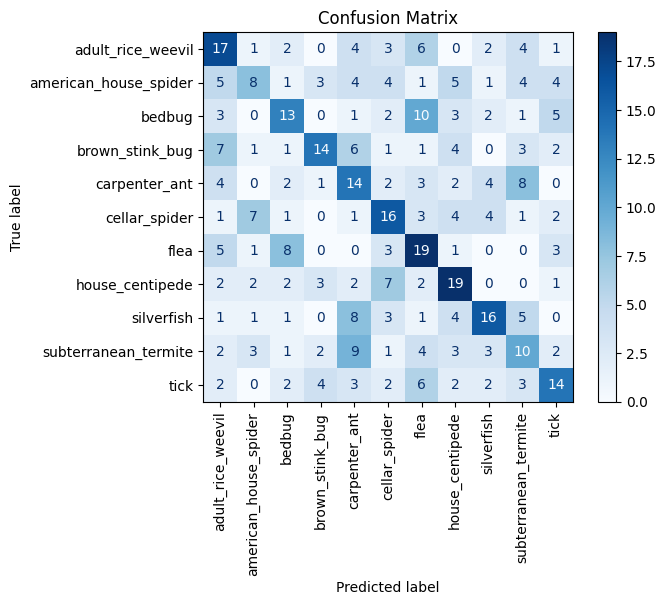

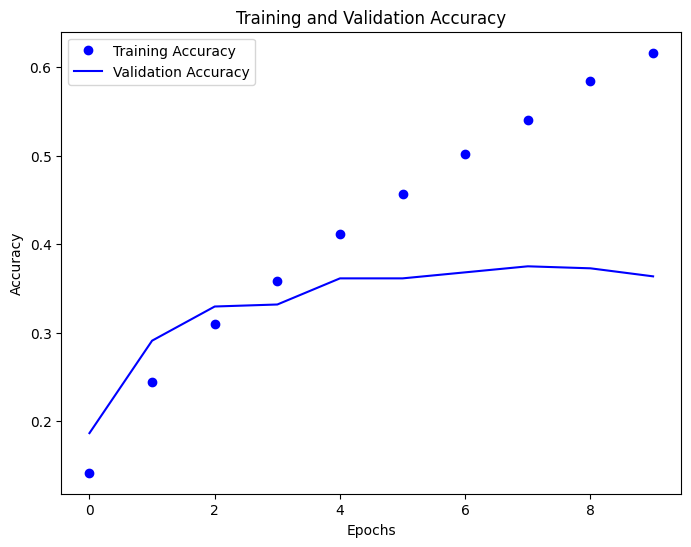

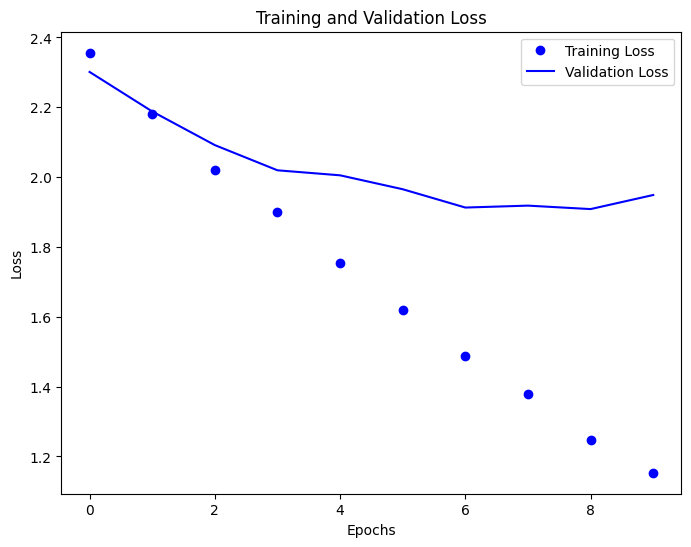

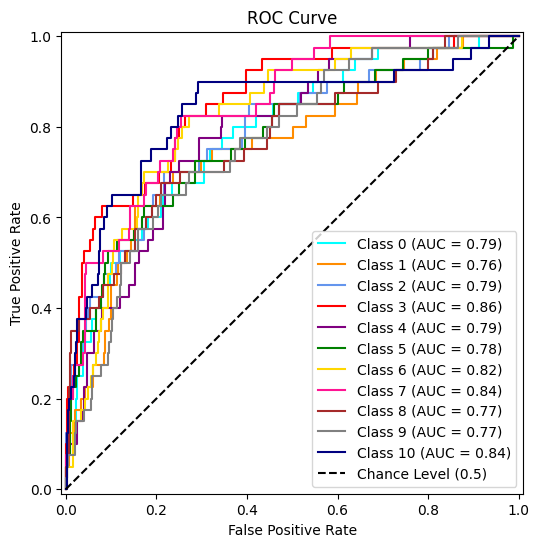

Macro-averaged One-vs-One ROC AUC score: 0.80
Accuracy: 0.364
Precision: 0.372
Recall: 0.364
F1 Score: 0.362


In [16]:
# CNN - BASE ONLY, NO transfer learning
basic_cnn_model, basic_training_history = full_build_cnn(epoch_num=10)
basic_test_loss, basic_test_acc = evaluate_model(basic_cnn_model)

# Run evaluation metrics on base cnn model 
basic_model_metrics = evaluation_metrics(basic_cnn_model, EVAL_VAL_GENERATOR, basic_training_history)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 126s 649ms/step - accuracy: 0.1113 - loss: 2.8011 - val_accuracy: 0.1568 - val_loss: 2.3710
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 125s 655ms/step - accuracy: 0.1182 - loss: 2.3720 - val_accuracy: 0.1364 - val_loss: 2.3504
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 120s 628ms/step - accuracy: 0.1199 - loss: 2.3582 - val_accuracy: 0.1500 - val_loss: 2.3573
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 119s 625ms/step - accuracy: 0.1304 - loss: 2.3393 - val_accuracy: 0.1477 - val_loss: 2.3414
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 119s 623ms/step - accuracy: 0.1354 - loss: 2.3391 - val_accuracy: 0.1682 - val_loss: 2.3287
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 120s 626ms/step - accuracy: 0.1354 - loss: 2.3299 - val_accuracy: 0.1614 - val_loss: 2.3192
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 123s 644ms/step - accuracy: 0.1259 - loss: 2.3263 - val_accuracy: 0.1795 - val_loss: 2.3223
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 124s 650ms/step - accuracy: 0.1330 -

Validation Accuracy: 0.1795
Validation Loss: 2.3018
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 562ms/step
Classification Report:


/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

,precision,recall,f1-score,support
adult_rice_weevil,0.214286,0.150000,0.176471,40.000000
american_house_spider,0.000000,0.000000,0.000000,40.000000
bedbug,0.500000,0.050000,0.090909,40.000000
brown_stink_bug,0.000000,0.000000,0.000000,40.000000
carpenter_ant,0.212598,0.675000,0.323353,40.000000
cellar_spider,0.152632,0.725000,0.252174,40.000000
flea,0.210526,0.200000,0.205128,40.000000
house_centipede,0.000000,0.000000,0.000000,40.000000
silverfish,0.250000,0.075000,0.115385,40.000000
subterranean_termite,0.103448,0.075000,0.086957,40.000000


<Figure size 800x600 with 0 Axes>

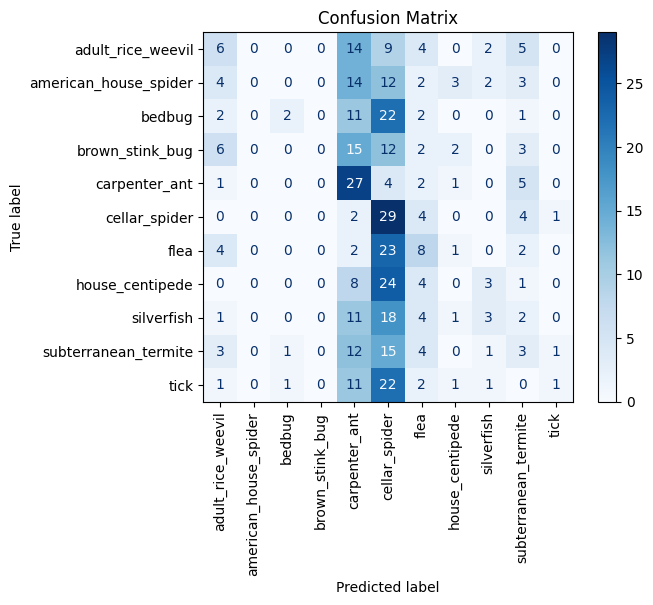

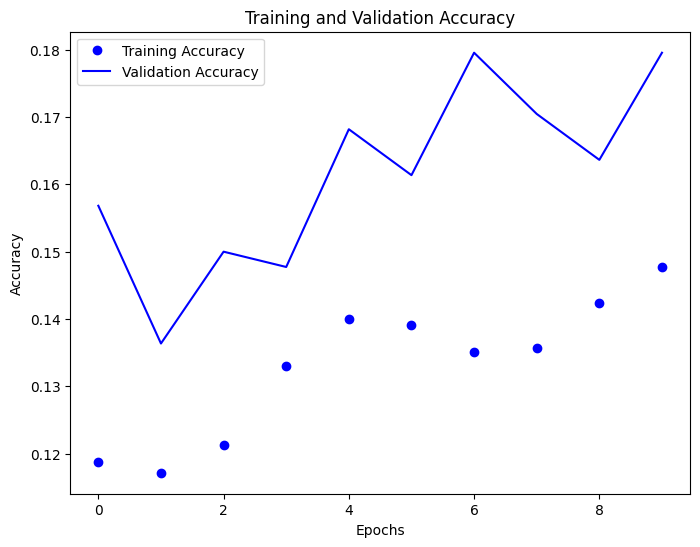

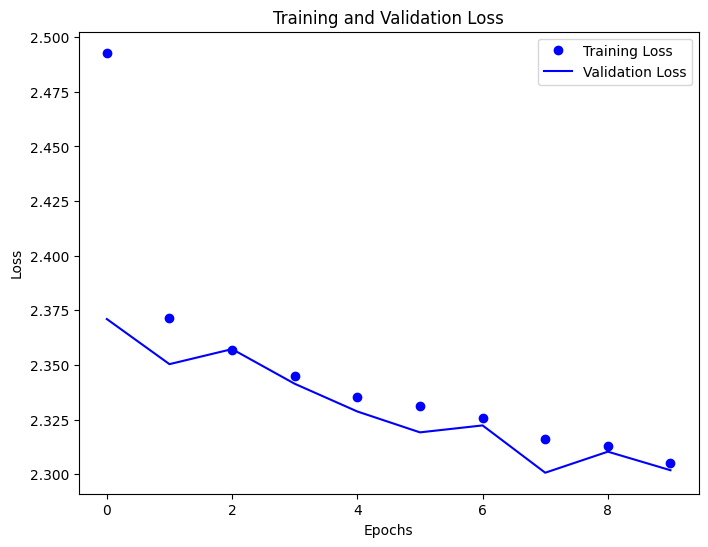

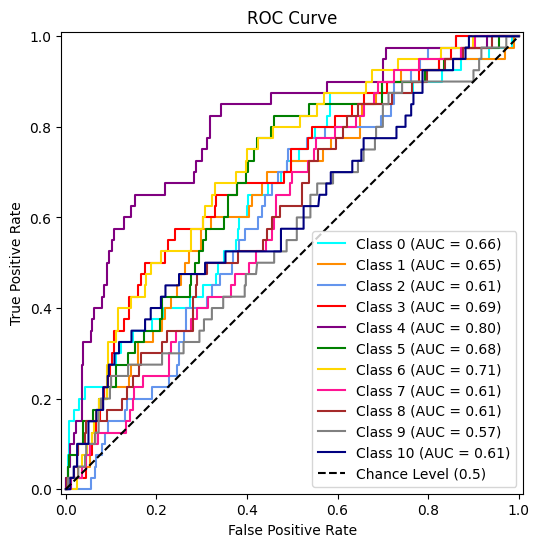

Macro-averaged One-vs-Rest ROC AUC score: 0.65
Accuracy: 0.18
Precision: 0.18
Recall: 0.18
F1 Score: 0.118


In [7]:
# CNN - Transfer learning with ResNet50
resnet_model,resnet_training_history = full_build_cnn(use_transfer_learning = True, transfer_model_name = "ResNet50",epoch_num=10)
resnet_test_loss, resnet_test_acc = evaluate_model(resnet_model, filename = "pest_classifier_cnn_resnet.h5")
resnet_model_metrics = evaluation_metrics(resnet_model, EVAL_VAL_GENERATOR, resnet_training_history)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 56s 279ms/step - accuracy: 0.0948 - loss: 2.8408 - val_accuracy: 0.0909 - val_loss: 2.3979
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 53s 278ms/step - accuracy: 0.1056 - loss: 2.3986 - val_accuracy: 0.0909 - val_loss: 2.3979
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 54s 285ms/step - accuracy: 0.1116 - loss: 2.3976 - val_accuracy: 0.0909 - val_loss: 2.3979
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 55s 288ms/step - accuracy: 0.1055 - loss: 2.3972 - val_accuracy: 0.0909 - val_loss: 2.3979
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 55s 290ms/step - accuracy: 0.1017 - loss: 2.3972 - val_accuracy: 0.0909 - val_loss: 2.3980
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 55s 289ms/step - accuracy: 0.1057 - loss: 2.3970 - val_accuracy: 0.0909 - val_loss: 2.3980
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 54s 284ms/step - accuracy: 0.0949 - loss: 2.3971 - val_accuracy: 0.0909 - val_loss: 2.3980
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 53s 275ms/step - accuracy: 0.1068 - loss: 2

Validation Accuracy: 0.0909
Validation Loss: 2.3982
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step
Classification Report:


/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

,precision,recall,f1-score,support
adult_rice_weevil,0.090909,1.000000,0.166667,40.000000
american_house_spider,0.000000,0.000000,0.000000,40.000000
bedbug,0.000000,0.000000,0.000000,40.000000
brown_stink_bug,0.000000,0.000000,0.000000,40.000000
carpenter_ant,0.000000,0.000000,0.000000,40.000000
cellar_spider,0.000000,0.000000,0.000000,40.000000
flea,0.000000,0.000000,0.000000,40.000000
house_centipede,0.000000,0.000000,0.000000,40.000000
silverfish,0.000000,0.000000,0.000000,40.000000
subterranean_termite,0.000000,0.000000,0.000000,40.000000


<Figure size 800x600 with 0 Axes>

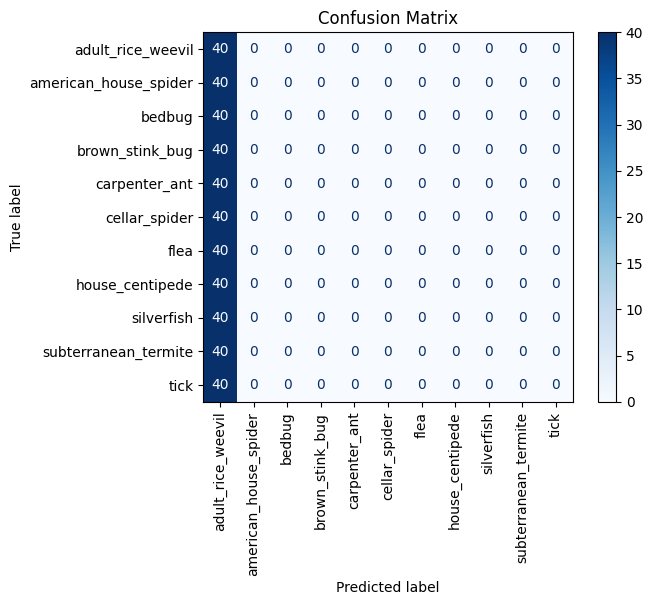

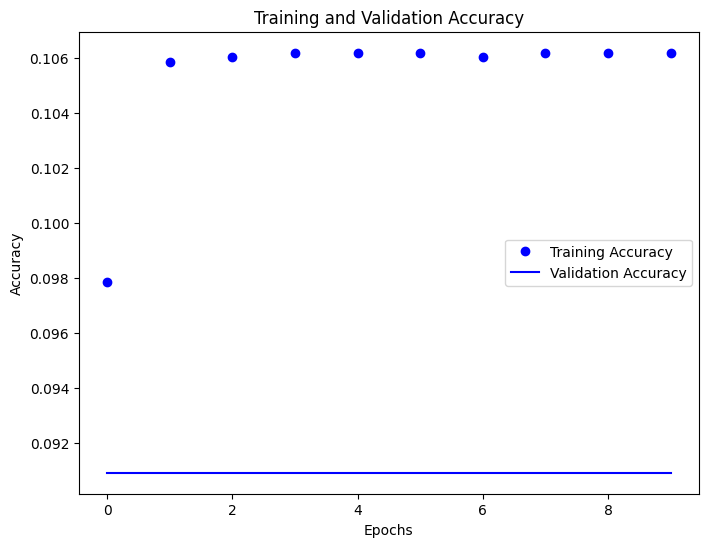

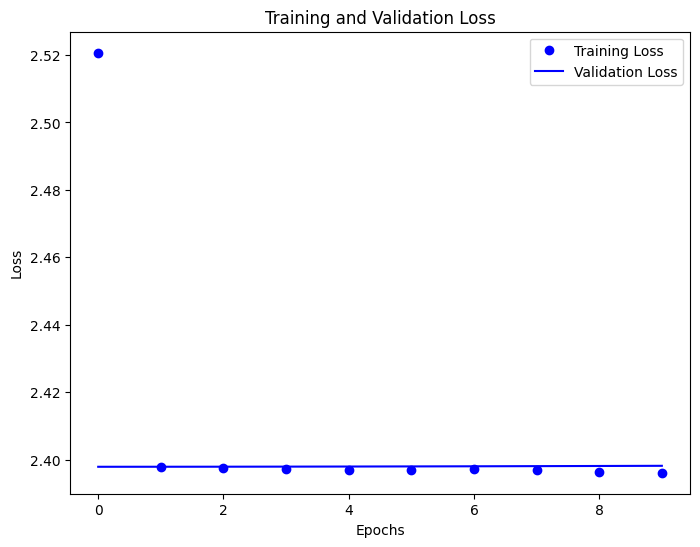

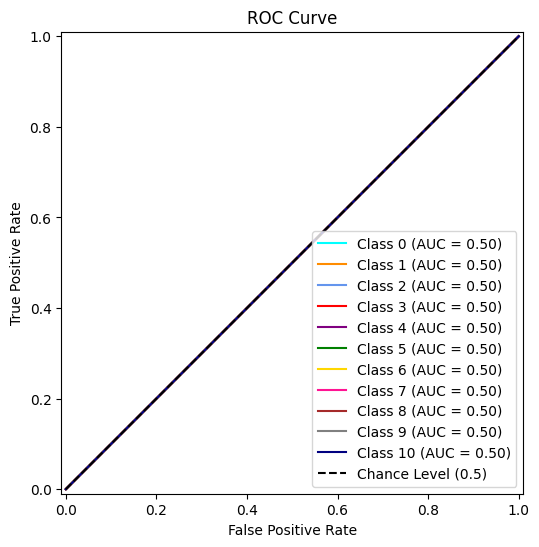

Macro-averaged One-vs-Rest ROC AUC score: 0.50
Accuracy: 0.091
Precision: 0.008
Recall: 0.091
F1 Score: 0.015


In [9]:
# CNN - Transfer learning with EfficientNet
efficientnet_model, efficientnet_training_history = full_build_cnn(use_transfer_learning=True, transfer_model_name="EfficientNet", epoch_num=10)
efficientnet_test_loss, efficientnet_test_acc = evaluate_model(efficientnet_model, filename="pest_classifier_cnn_efficientnet.h5")

# Run evaluation metrics
efficientnet_model_metrics = evaluation_metrics(efficientnet_model, EVAL_VAL_GENERATOR, efficientnet_training_history)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.2869 - loss: 2.1218 - val_accuracy: 0.4682 - val_loss: 1.5186
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.6124 - loss: 1.2104 - val_accuracy: 0.5477 - val_loss: 1.3519
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.7042 - loss: 0.9417 - val_accuracy: 0.5795 - val_loss: 1.2837
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.7612 - loss: 0.7582 - val_accuracy: 0.5705 - val_loss: 1.2800
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.8170 - loss: 0.6141 - val_accuracy: 0.6091 - val_loss: 1.2665
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.8521 - loss: 0.5241 - val_accuracy: 0.6205 - val_loss: 1.2506
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.8805 - loss: 0.4350 - val_accuracy: 0.5841 - val_loss: 1.2936
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.8976 - loss: 0.3630 - val_accu

Validation Accuracy: 0.6205
Validation Loss: 1.2855
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Classification Report:


,precision,recall,f1-score,support
adult_rice_weevil,0.638298,0.750000,0.689655,40.000000
american_house_spider,0.566667,0.425000,0.485714,40.000000
bedbug,0.490196,0.625000,0.549451,40.000000
brown_stink_bug,0.800000,0.700000,0.746667,40.000000
carpenter_ant,0.571429,0.600000,0.585366,40.000000
cellar_spider,0.622222,0.700000,0.658824,40.000000
flea,0.472222,0.425000,0.447368,40.000000
house_centipede,1.000000,0.750000,0.857143,40.000000
silverfish,0.735294,0.625000,0.675676,40.000000
subterranean_termite,0.468750,0.375000,0.416667,40.000000


<Figure size 800x600 with 0 Axes>

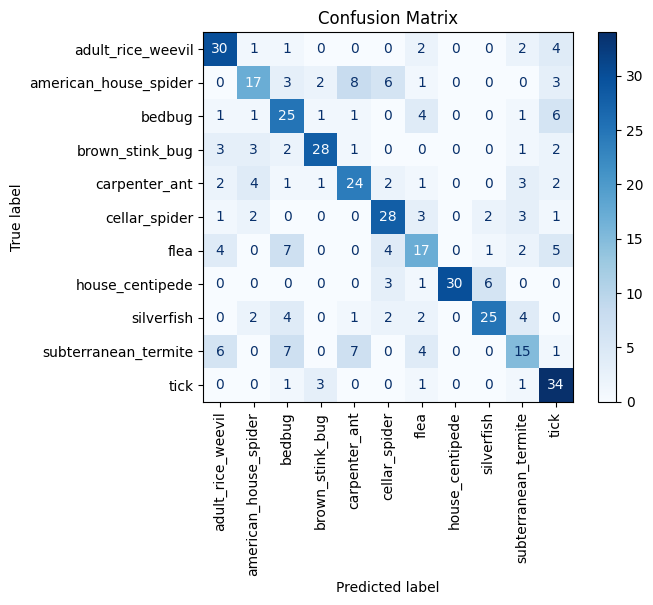

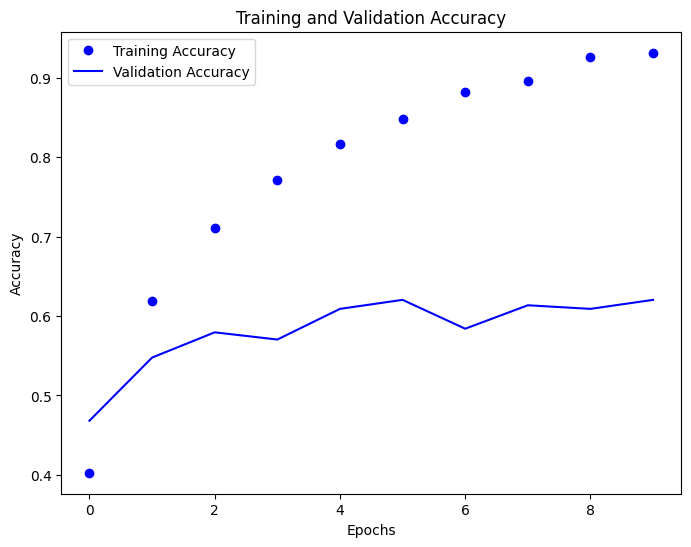

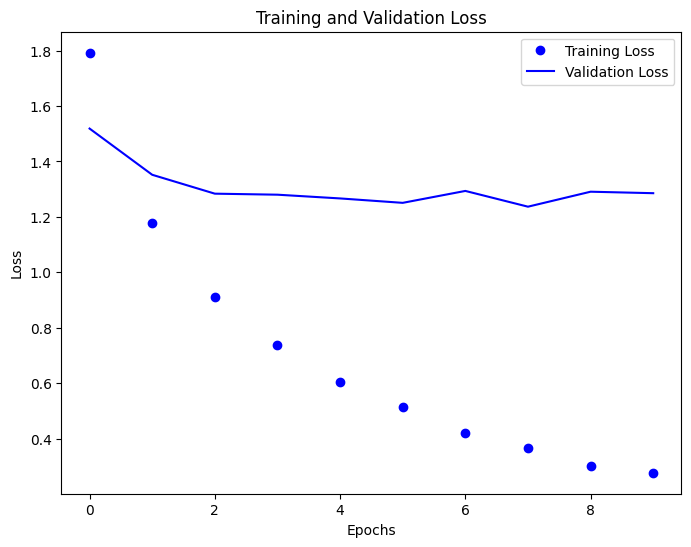

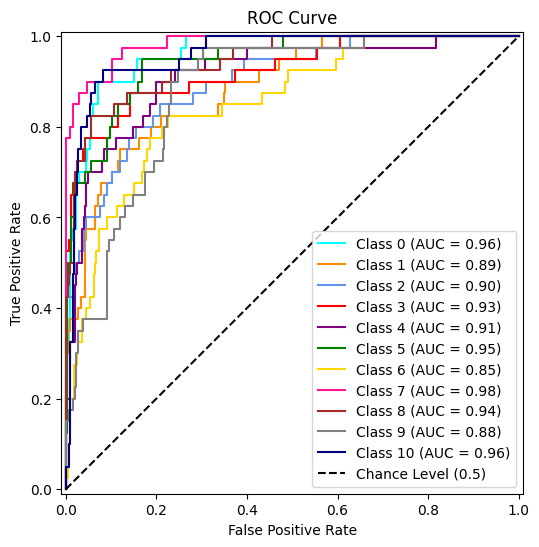

Macro-averaged One-vs-Rest ROC AUC score: 0.92
Accuracy: 0.62
Precision: 0.632
Recall: 0.62
F1 Score: 0.619


In [10]:
# CNN - Transfer learning with VGG16
vgg16_model, vgg16_training_history = full_build_cnn(use_transfer_learning=True, transfer_model_name="VGG16", epoch_num=10)
vgg16_test_loss, vgg16_test_acc = evaluate_model(vgg16_model, filename="pest_classifier_cnn_vgg16.h5")

# Run evaluation metrics
vgg16_model_metrics = evaluation_metrics(vgg16_model, EVAL_VAL_GENERATOR, vgg16_training_history)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - accuracy: 0.5083 - loss: 1.9630 - val_accuracy: 0.6886 - val_loss: 1.0268
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 185ms/step - accuracy: 0.8462 - loss: 0.4537 - val_accuracy: 0.6727 - val_loss: 1.1696
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 183ms/step - accuracy: 0.9109 - loss: 0.2686 - val_accuracy: 0.6977 - val_loss: 0.9849
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 184ms/step - accuracy: 0.9535 - loss: 0.1390 - val_accuracy: 0.7045 - val_loss: 1.1660
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 185ms/step - accuracy: 0.9658 - loss: 0.1023 - val_accuracy: 0.7114 - val_loss: 1.2197
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 36s 186ms/step - accuracy: 0.9685 - loss: 0.0892 - val_accuracy: 0.6977 - val_loss: 1.2003
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 36s 189ms/step - accuracy: 0.9724 - loss: 0.0852 - val_accuracy: 0.6977 - val_loss: 1.3775
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━

Validation Accuracy: 0.6955
Validation Loss: 1.5336
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step
Classification Report:


,precision,recall,f1-score,support
adult_rice_weevil,0.688889,0.775000,0.729412,40.000000
american_house_spider,0.920000,0.575000,0.707692,40.000000
bedbug,0.492063,0.775000,0.601942,40.000000
brown_stink_bug,0.794872,0.775000,0.784810,40.000000
carpenter_ant,0.697674,0.750000,0.722892,40.000000
cellar_spider,0.790698,0.850000,0.819277,40.000000
flea,0.475000,0.475000,0.475000,40.000000
house_centipede,0.857143,0.750000,0.800000,40.000000
silverfish,0.731707,0.750000,0.740741,40.000000
subterranean_termite,0.680000,0.425000,0.523077,40.000000


<Figure size 800x600 with 0 Axes>

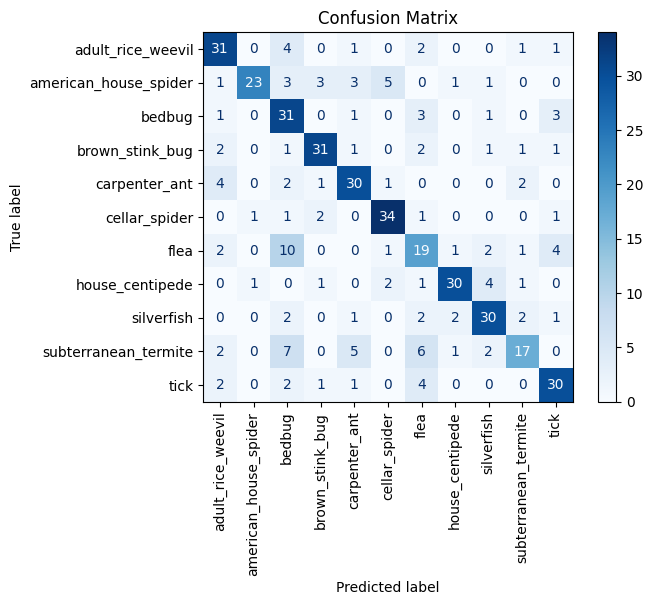

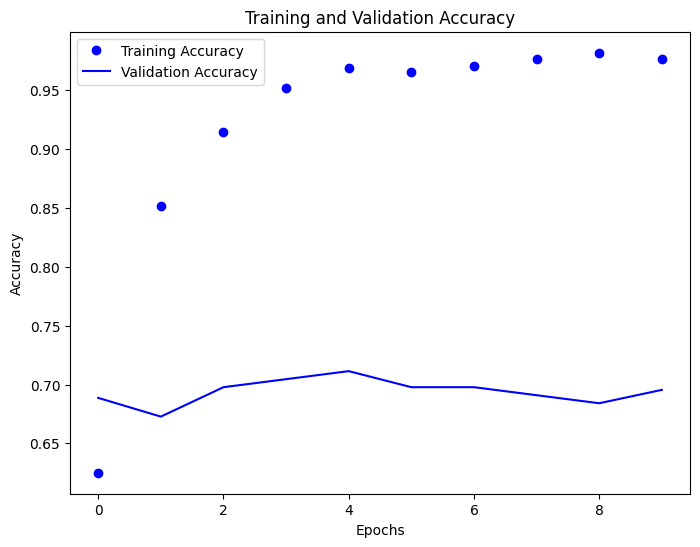

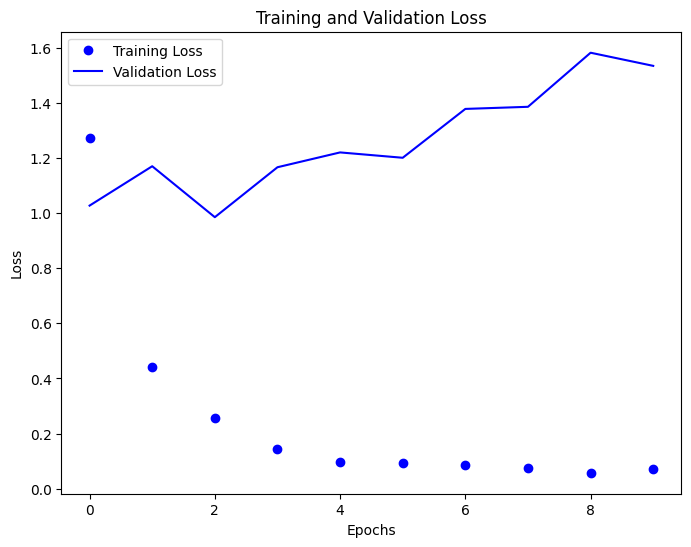

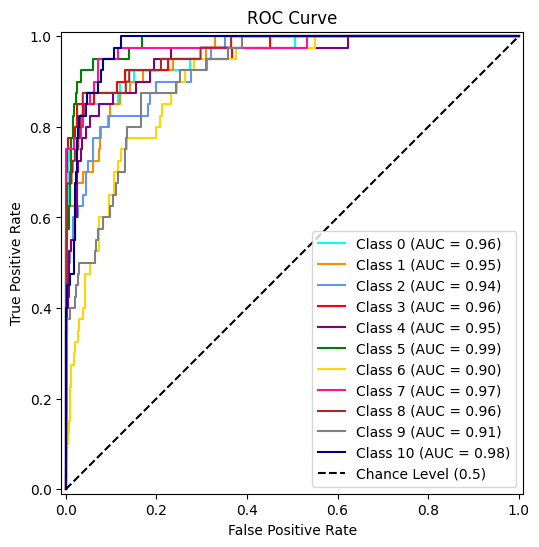

Macro-averaged One-vs-One ROC AUC score: 0.95
Accuracy: 0.695
Precision: 0.715
Recall: 0.695
F1 Score: 0.695


In [13]:
# CNN - Transfer learning with MobileNetV2
mobilenetv2_model, mobilenetv2_training_history = full_build_cnn(use_transfer_learning=True, transfer_model_name="MobileNetV2", epoch_num=10)
mobilenetv2_test_loss, mobilenetv2_test_acc = evaluate_model(mobilenetv2_model, filename="pest_classifier_cnn_mobilenetv2.h5")

# Run evaluation metrics
mobilenetv2_model_metrics = evaluation_metrics(mobilenetv2_model, EVAL_VAL_GENERATOR, mobilenetv2_training_history)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 190s 961ms/step - accuracy: 0.5443 - loss: 1.7374 - val_accuracy: 0.7409 - val_loss: 0.7991
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 182s 953ms/step - accuracy: 0.8525 - loss: 0.4372 - val_accuracy: 0.7500 - val_loss: 0.7650
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 180s 943ms/step - accuracy: 0.9154 - loss: 0.2442 - val_accuracy: 0.7886 - val_loss: 0.7916
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 178s 932ms/step - accuracy: 0.9507 - loss: 0.1464 - val_accuracy: 0.7545 - val_loss: 0.9306
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 178s 932ms/step - accuracy: 0.9684 - loss: 0.0946 - val_accuracy: 0.7614 - val_loss: 0.9622
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 178s 931ms/step - accuracy: 0.9789 - loss: 0.0710 - val_accuracy: 0.7636 - val_loss: 0.9195
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 178s 931ms/step - accuracy: 0.9796 - loss: 0.0669 - val_accuracy: 0.7682 - val_loss: 1.0432
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 179s 937ms/step - accuracy: 0.9816 -

Validation Accuracy: 0.7659
Validation Loss: 1.0757
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 944ms/step
Classification Report:


,precision,recall,f1-score,support
adult_rice_weevil,0.909091,0.750000,0.821918,40.000000
american_house_spider,0.937500,0.750000,0.833333,40.000000
bedbug,0.604167,0.725000,0.659091,40.000000
brown_stink_bug,0.804348,0.925000,0.860465,40.000000
carpenter_ant,0.761905,0.800000,0.780488,40.000000
cellar_spider,0.939394,0.775000,0.849315,40.000000
flea,0.446429,0.625000,0.520833,40.000000
house_centipede,0.878049,0.900000,0.888889,40.000000
silverfish,0.842105,0.800000,0.820513,40.000000
subterranean_termite,0.821429,0.575000,0.676471,40.000000


<Figure size 800x600 with 0 Axes>

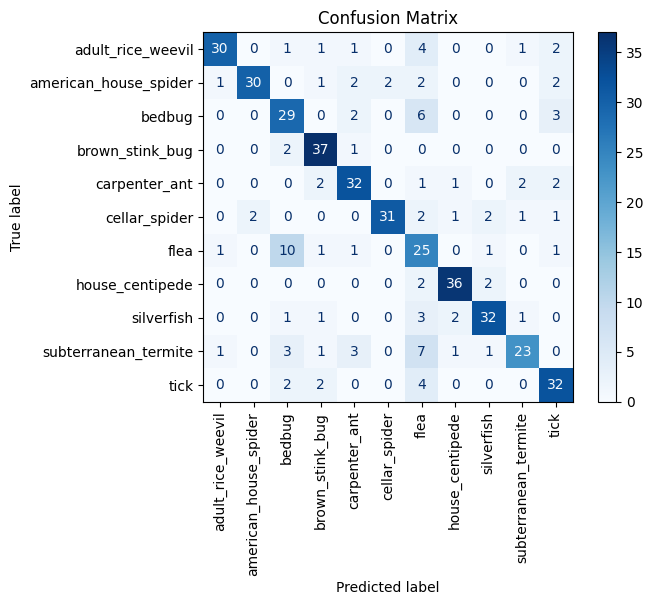

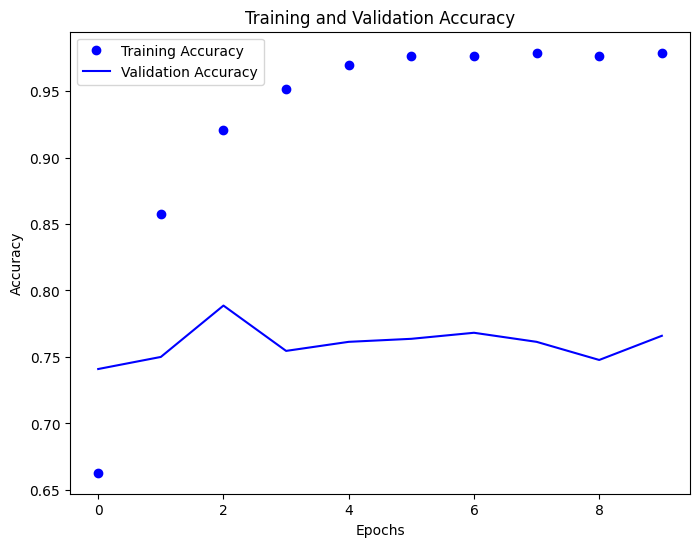

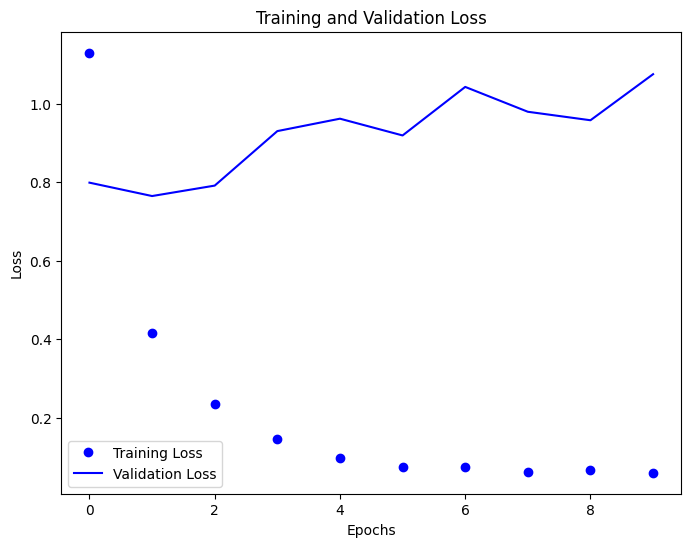

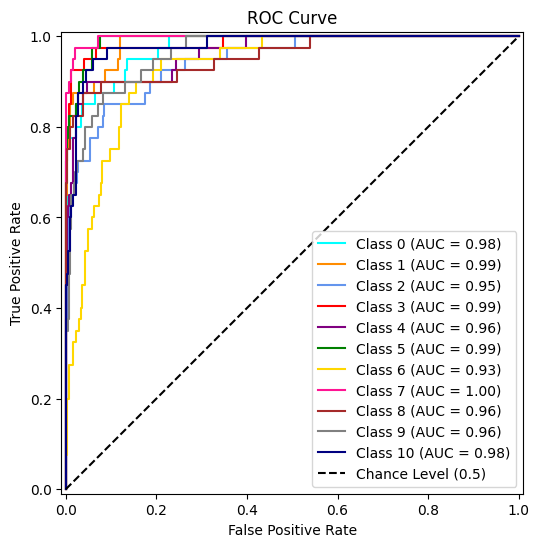

Macro-averaged One-vs-One ROC AUC score: 0.97
Accuracy: 0.766
Precision: 0.79
Recall: 0.766
F1 Score: 0.771


In [14]:
# CNN - Transfer learning with DenseNet201
densenet201_model, densenet201_training_history = full_build_cnn(use_transfer_learning=True, transfer_model_name="DenseNet201", epoch_num=10)
densenet201_test_loss, densenet201_test_acc = evaluate_model(densenet201_model, filename="pest_classifier_cnn_densenet201.h5")

# Run evaluation metrics
densenet201_model_metrics = evaluation_metrics(densenet201_model, EVAL_VAL_GENERATOR, densenet201_training_history)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 131s 681ms/step - accuracy: 0.5780 - loss: 1.4350 - val_accuracy: 0.6773 - val_loss: 0.9939
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 131s 686ms/step - accuracy: 0.8164 - loss: 0.5518 - val_accuracy: 0.6955 - val_loss: 0.9963
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 130s 683ms/step - accuracy: 0.9154 - loss: 0.2806 - val_accuracy: 0.6932 - val_loss: 1.0454
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 130s 683ms/step - accuracy: 0.9462 - loss: 0.1802 - val_accuracy: 0.7091 - val_loss: 1.0329
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 133s 694ms/step - accuracy: 0.9490 - loss: 0.1586 - val_accuracy: 0.7182 - val_loss: 1.0746
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 133s 696ms/step - accuracy: 0.9663 - loss: 0.1154 - val_accuracy: 0.6909 - val_loss: 1.1811
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 131s 685ms/step - accuracy: 0.9698 - loss: 0.0943 - val_accuracy: 0.7182 - val_loss: 1.1081
Epoch 8/10
191/191 ━━━━━━

Validation Accuracy: 0.7091
Validation Loss: 1.2546
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 589ms/step
Classification Report:


,precision,recall,f1-score,support
adult_rice_weevil,0.800000,0.700000,0.746667,40.000000
american_house_spider,0.837838,0.775000,0.805195,40.000000
bedbug,0.595238,0.625000,0.609756,40.000000
brown_stink_bug,0.809524,0.850000,0.829268,40.000000
carpenter_ant,0.771429,0.675000,0.720000,40.000000
cellar_spider,0.794872,0.775000,0.784810,40.000000
flea,0.347826,0.400000,0.372093,40.000000
house_centipede,0.900000,0.900000,0.900000,40.000000
silverfish,0.750000,0.750000,0.750000,40.000000
subterranean_termite,0.682927,0.700000,0.691358,40.000000


<Figure size 800x600 with 0 Axes>

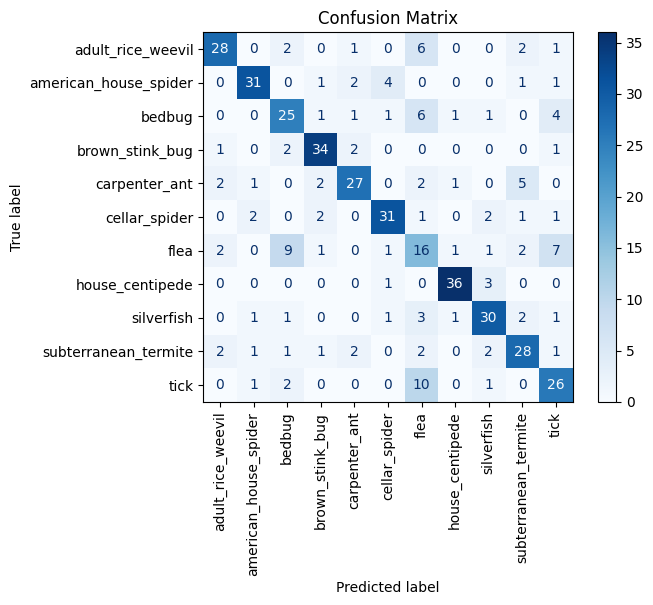

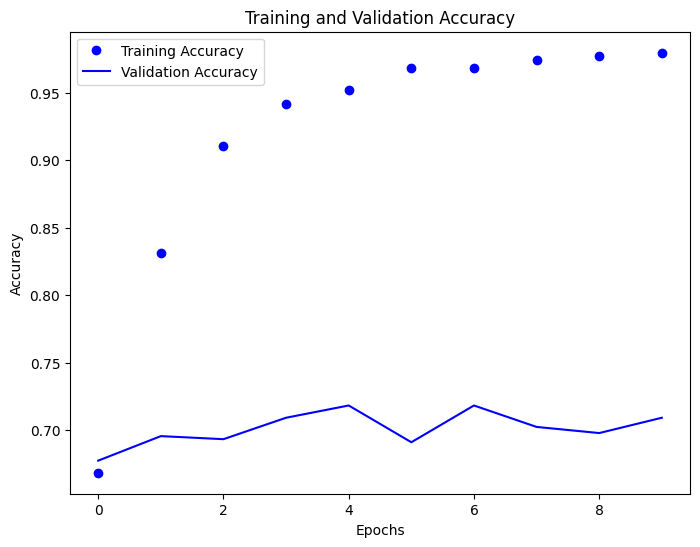

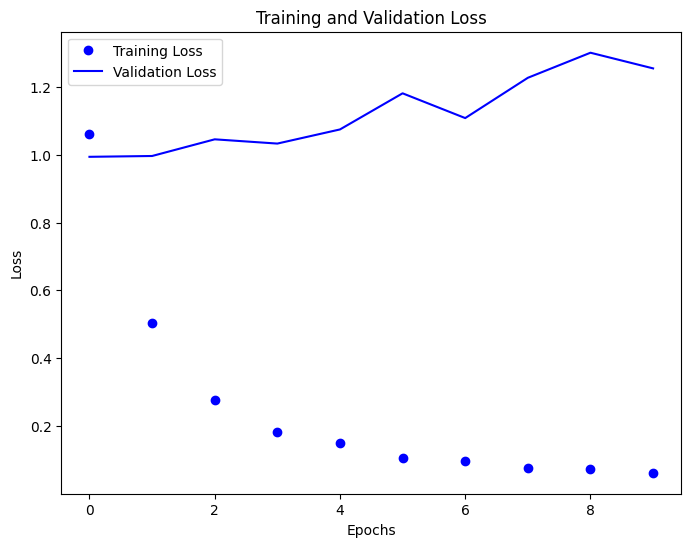

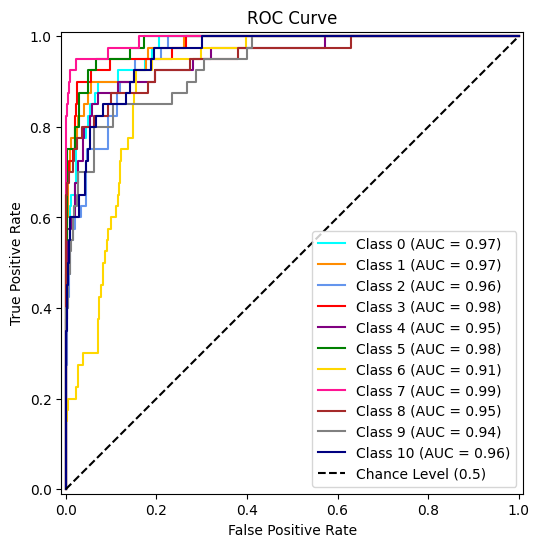

Macro-averaged One-vs-One ROC AUC score: 0.96
Accuracy: 0.709
Precision: 0.718
Recall: 0.709
F1 Score: 0.712


In [15]:
# CNN - Transfer learning with Xception
xception_model, xception_training_history = full_build_cnn(use_transfer_learning=True, transfer_model_name="Xception", epoch_num=10)
xception_test_loss, xception_test_acc = evaluate_model(xception_model, filename="pest_classifier_cnn_xception.h5")

# Run evaluation metrics
xception_model_metrics = evaluation_metrics(xception_model, EVAL_VAL_GENERATOR, xception_training_history)
